In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean

In [22]:
# Set random seed for reproducibility
np.random.seed()

In [23]:
# Simulation parameters
number_of_cars = int(input("Enter Number of Cars")) 
number_of_simulations = int(input("Enter Number of Runs"))

inter_arrival_times = [0, 1, 2, 3]
inter_arrival_probabilities = [0.17, 0.23, 0.25, 0.35]

categories = ["A", "B", "C"]
category_probabilities = [0.2, 0.35, 0.45]

service_times_A_B = [1, 2, 3]
service_probabilities_A_B = [0.2, 0.3, 0.5]

service_times_C = [3, 5, 7]
service_probabilities_C = [0.2, 0.5, 0.3]

Enter Number of Cars 100
Enter Number of Runs 1000


In [24]:
def display_theoretical_avg(arr,title):
    plt.hist(arr,color = 'purple')
    plt.title(title)
    print(np.nanmean(arr))

In [25]:
def calculate_pump_length(pump):
    ans = 0
    for i in pump_queues[pump]:
        if i['service_end_time'] > time:
            ans+=1
    
    return ans

In [26]:
def update_max_pump_queue_length():
    max_pump_queue_length["95 Octane"] = max(max_pump_queue_length["95 Octane"],calculate_pump_length("95 Octane"))
    max_pump_queue_length["90 Octane"] = max(max_pump_queue_length["90 Octane"],calculate_pump_length("90 Octane"))
    max_pump_queue_length["Gas"] = max(max_pump_queue_length["Gas"],calculate_pump_length("Gas"))
    
    # print(f"{time}, {"95 Octane"} , {max_pump_queue_length["95 Octane"]}")
    # print(f"{time}, {"90 Octane"} , {max_pump_queue_length["90 Octane"]}")
    # print(f"{time}, {"Gas"} , {max_pump_queue_length["Gas"]}")

In [27]:
experimental_average_of_interarrival = []
experimental_average_of_service_time_a_b = []
experimental_average_of_service_time_c = []

In [28]:
for j in range(number_of_simulations):
    # Initialize variables
    i = 0
    time = 0
    events = []
    pump_idle_time = {"95 Octane": 0, "90 Octane": 0, "Gas": 0}
    pump_queues = {"95 Octane": [], "90 Octane": [], "Gas": []}
    last_pump_free_time = {"95 Octane": 0, "90 Octane": 0, "Gas": 0}
    max_pump_queue_length = {"95 Octane": 0, "90 Octane": 0, "Gas": 0}
    
    for i in range(number_of_cars):
        # Assign Independent Values (Inter-arrival Time, Car Category)
        inter_arrival = np.random.choice(inter_arrival_times, p=inter_arrival_probabilities)
        time += inter_arrival
    
        car_category = np.random.choice(categories, p=category_probabilities)
    
        # Here We Assign Dependent Values (Service time, Pump)
    
        # Assign Service Time based on the Car a
        if car_category in ["A", "B"]:
            service_time = np.random.choice(service_times_A_B, p=service_probabilities_A_B)
        else:
            service_time = np.random.choice(service_times_C, p=service_probabilities_C)
    
        # Determine pump assignment
        if car_category == "B":
            if calculate_pump_length("90 Octane") > 3:  # More than 3 cars in the "90 Octane" queue
                pump = "95 Octane" if np.random.rand() < 0.6 else "90 Octane"
            else:
                pump = "90 Octane"
        elif car_category == "C":
            if calculate_pump_length("Gas") > 4:  # More than 4 cars in the "Gas" queue
                pump = "90 Octane" if np.random.rand() < 0.4 else "Gas"
            else:
                pump = "Gas"
        else:  # Category A
            pump = "95 Octane"
        # Calculate waiting time and start/end times
    
        # if the queue is empty then the waiting time is the service end time of the last one in the pump - the current time
        waiting_time = max(0, last_pump_free_time[pump] - time)
    
        service_start_time = time + waiting_time
        service_end_time = service_start_time + service_time
    
        # Update idle time for pump
        if service_start_time >= last_pump_free_time[pump]:
            pump_idle_time[pump] = service_start_time - last_pump_free_time[pump]
    
        # Record event
        event = {
            "inter-arrival_time": inter_arrival,
            "arrival_time": time,
            "car_category": car_category,
            "pump": pump,
            "service_time": service_time,
            "service_start_time": service_start_time,
            "service_end_time": service_end_time,
            "waiting_time": waiting_time,
            "chosen_pump_idle_time": pump_idle_time[pump],
        }
        events.append(event)
    
        # Update pump state
        pump_queues[pump].append(event)
        update_max_pump_queue_length()
        last_pump_free_time[pump] = service_end_time
        
    inter_arrival_times_in_events = [event["inter-arrival_time"] for event in events]
    service_times_in_events_for_a_b = [event["service_time"] for event in events if event["car_category"] in ["A", "B"]]
    service_times_in_events_for_c = [event["service_time"] for event in events if event["car_category"] in ["C"]]
    
    mean_of_interarrival_time_in_events = np.mean(inter_arrival_times_in_events)
    mean_of_a_b_service_time = np.mean(service_times_in_events_for_a_b)
    mean_of_c_service_time = np.mean(service_times_in_events_for_c)

    experimental_average_of_interarrival.append(mean_of_interarrival_time_in_events)
    experimental_average_of_service_time_a_b.append(mean_of_a_b_service_time)
    experimental_average_of_service_time_c.append(mean_of_c_service_time)
    

In [29]:
df = pd.DataFrame(events)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [30]:
data = df
# 1. Average service time of cars in the three categories
avg_service_time = data.groupby('car_category')['service_time'].mean()

# 2. Average waiting time in the queues for each pump, and all cars
avg_waiting_time_by_pump = data.groupby('pump')['waiting_time'].mean()
avg_waiting_time_all = data['waiting_time'].mean()

# 3. Maximum queue length for each pump (approximated as cars waiting for service at the same pump)
queue_lengths = data.groupby('pump').size()

# 4. Probability that a car waits for each pump
prob_wait_by_pump = data[data['waiting_time'] > 0].groupby('pump').size() / data.groupby('pump').size()

# 5. Portion of idle time of each pump
total_idle_time_by_pump = data.groupby('pump')['chosen_pump_idle_time'].sum()
total_time = data['service_end_time'].max()  # Assuming service_end_time covers all events
idle_time_portion = total_idle_time_by_pump / total_time


service_time_of_each_pump = data.groupby('pump')['service_time'].sum()
utilization_of_each_pump = service_time_of_each_pump/total_time*100

count_of_each_service_time = data.groupby('service_time')['service_time'].count()


1.77236


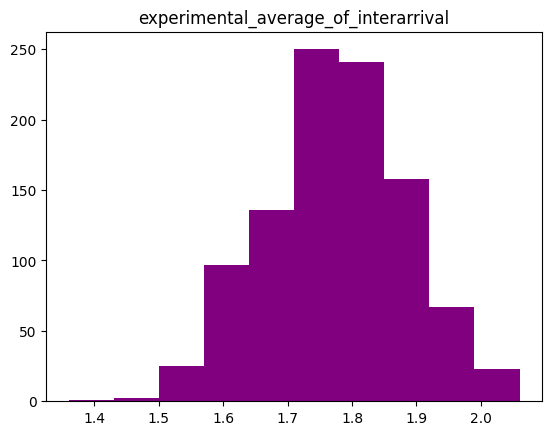

In [31]:
display_theoretical_avg(experimental_average_of_interarrival,'experimental_average_of_interarrival')

2.297497767232546


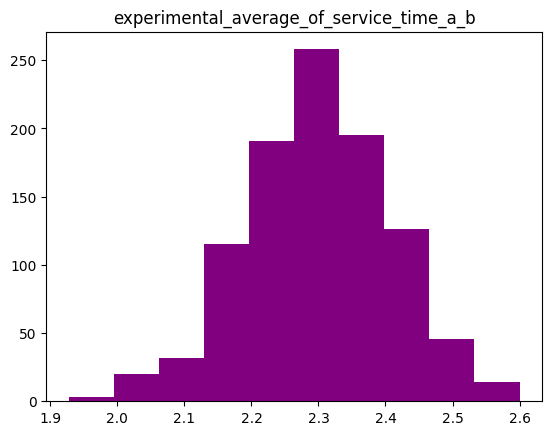

In [32]:
display_theoretical_avg(experimental_average_of_service_time_a_b,'experimental_average_of_service_time_a_b')

5.201018719079912


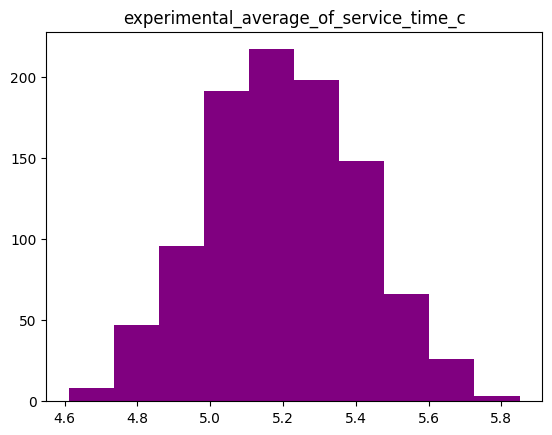

In [33]:
display_theoretical_avg(experimental_average_of_service_time_c,'experimental_average_of_service_time_c')

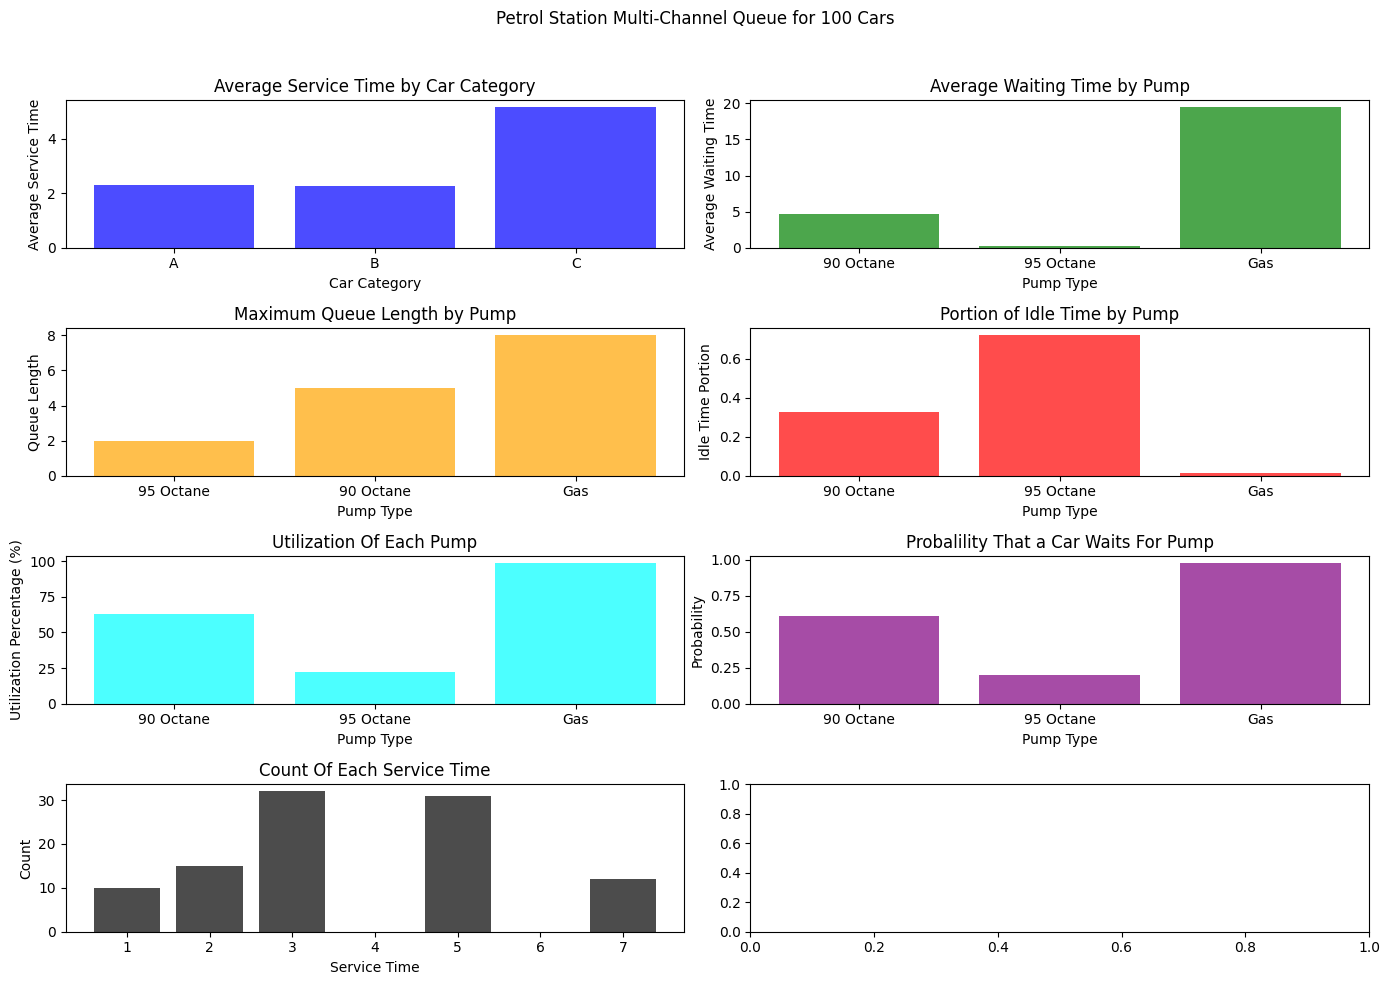

In [34]:
# Visualization
fig, axes = plt.subplots(4,2, figsize=(14, 10))
fig.suptitle(f'Petrol Station Multi-Channel Queue for {number_of_cars} Cars')

# Plot 1: Average service time by car category
axes[0, 0].bar(avg_service_time.index, avg_service_time.values, color='blue', alpha=0.7)
axes[0, 0].set_title('Average Service Time by Car Category')
axes[0, 0].set_xlabel('Car Category')
axes[0, 0].set_ylabel('Average Service Time')

# Plot 2: Average waiting time by pump
axes[0, 1].bar(avg_waiting_time_by_pump.index, avg_waiting_time_by_pump.values, color='green', alpha=0.7)
axes[0, 1].set_title('Average Waiting Time by Pump')
axes[0, 1].set_xlabel('Pump Type')
axes[0, 1].set_ylabel('Average Waiting Time')

# # Plot 3: Maximum queue length by pump
# axes[1, 0].bar(queue_lengths.index, queue_lengths.values, color='orange', alpha=0.7)
# axes[1, 0].set_title('Maximum Queue Length by Pump')
# axes[1, 0].set_xlabel('Pump Type')
# axes[1, 0].set_ylabel('Queue Length')

# Plot 3: Maximum queue length by pump
axes[1, 0].bar(list(max_pump_queue_length.keys()), list(max_pump_queue_length.values()), color='orange', alpha=0.7)
axes[1, 0].set_title('Maximum Queue Length by Pump')
axes[1, 0].set_xlabel('Pump Type')
axes[1, 0].set_ylabel('Queue Length')

# Plot 4: Portion of idle time by pump
axes[1, 1].bar(idle_time_portion.index, idle_time_portion.values, color='red', alpha=0.7)
axes[1, 1].set_title('Portion of Idle Time by Pump')
axes[1, 1].set_xlabel('Pump Type')
axes[1, 1].set_ylabel('Idle Time Portion')

# Plot 5: Utilization Percentage of each pump
axes[2, 0].bar(utilization_of_each_pump.index, utilization_of_each_pump.values, color='cyan', alpha=0.7)
axes[2, 0].set_title('Utilization Of Each Pump')
axes[2, 0].set_xlabel('Pump Type')
axes[2, 0].set_ylabel('Utilization Percentage (%)')

# Plot 6: Probability of having a car waiting for each pump
axes[2, 1].bar(prob_wait_by_pump.index, prob_wait_by_pump.values, color='purple', alpha=0.7)
axes[2, 1].set_title('Probalility That a Car Waits For Pump')
axes[2, 1].set_xlabel('Pump Type')
axes[2, 1].set_ylabel('Probability')

# Plot 7: Count Of Each Service Time
axes[3, 0].bar(count_of_each_service_time.index, count_of_each_service_time.values, color='black', alpha=0.7)
axes[3, 0].set_title('Count Of Each Service Time')
axes[3, 0].set_xlabel('Service Time')
axes[3, 0].set_ylabel('Count')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [35]:
df.to_excel("output.xlsx",index = False)